# Evaluating a classification model


## Agenda

- What is the purpose of **model evaluation**, and what are some common evaluation procedures?
- What is the usage of **classification accuracy**, and what are its limitations?
- How does a **confusion matrix** describe the performance of a classifier?
- What **metrics** can be computed from a confusion matrix?
- How can you adjust classifier performance by **changing the classification threshold**?
- What is the purpose of an **ROC curve**?
- How does **Area Under the Curve (AUC)** differ from classification accuracy?

## Review of model evaluation

- Need a way to choose between models: different model types, tuning parameters, and features
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requires a **model evaluation metric** to quantify the model performance

### Model evaluation procedures

1. **Training and testing on the same data**
    - Rewards overly complex models that "overfit" the training data and won't necessarily generalize
2. **Train/test split**
    - Split the dataset into two pieces, so that the model can be trained and tested on different data
    - Better estimate of out-of-sample performance, but still a "high variance" estimate
    - Useful due to its speed, simplicity, and flexibility
3. **K-fold cross-validation**
    - Systematically create "K" train/test splits and average the results together
    - Even better estimate of out-of-sample performance
    - Runs "K" times slower than train/test split

### Model evaluation metrics

- **Regression problems:** Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
- **Classification problems:** Classification accuracy

<img src='./images/Exam_pass_logistic_curve.jpeg' width =500 />

In order to map a logistic regression value to a binary category, you must define a classification threshold (also called the decision threshold). A value above that threshold indicates "spam"; a value below indicates "not spam." It is tempting to assume that the classification threshold should always be 0.5, but thresholds are problem-dependent, and are therefore values that you must tune.


"Tuning" a threshold for logistic regression is different from tuning hyperparameters such as learning rate

## Classification accuracy

[Pima Indians Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) originally from the UCI Machine Learning Repository

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

In [2]:
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv'
titanic = pd.read_csv(url, index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Imputation function
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            
            return 29

        else:
            return 24

    else:
        return Age
    
# Apply the function to the Age column
titanic['Age']=titanic[['Age','Pclass']].apply(impute_age, axis =1 )   

In [4]:
# Remove Cabin feature
titanic.drop('Cabin', axis = 1, inplace = True)

In [5]:
# Remove rows with missing data
titanic.dropna(inplace = True)

In [6]:
# Data types
print(titanic.info())

# Identify non-null objects
print('\n')
print('Non-Null Objects to Be Converted to Category')
print(titanic.select_dtypes(['object']).columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 10 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.4+ KB
None


Non-Null Objects to Be Converted to Category
Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')


In [7]:
# Remove unnecessary columns  
titanic.drop(['Name','Ticket'], axis = 1, inplace = True)

# Convert objects to category data type
objcat = ['Sex','Embarked']

for colname in objcat:
    titanic[colname] = titanic[colname].astype('category')

In [8]:
# Convert categorical variables into 'dummy' or indicator variables
sex = pd.get_dummies(titanic['Sex'], drop_first = True) # drop_first prevents multi-collinearity
embarked = pd.get_dummies(titanic['Embarked'], drop_first = True)

In [9]:
# Add new dummy columns to data frame
titanic = pd.concat([titanic, sex, embarked], axis = 1)
titanic.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Q,S
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1,0,1
2,1,1,female,38.0,1,0,71.2833,C,0,0,0


In [10]:
# Drop unecessary columns
titanic.drop(['Sex', 'Embarked'], axis = 1, inplace = True)

# Shape of train data
print('train_data shape',titanic.shape)

# Confirm changes
titanic.head()

train_data shape (889, 9)


,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1


In [11]:
# Split data to be used in the models
# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict



In [12]:
# Use x and y variables to split the training data into train and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
dictionary = dict(zip(list(X_train.columns), list(logreg.coef_[0])))

In [15]:
dictionary

{'Pclass': -0.8081504356426106,
 'Age': -0.027343789530283137,
 'SibSp': -0.22799771291837126,
 'Parch': -0.014498151923564061,
 'Fare': 0.005250094656581603,
 'male': -2.1347976470988153,
 'Q': -0.03261700318029434,
 'S': -0.35795647775973893}

In [16]:
# read the data into a pandas DataFrame
import pandas as pd
path = 'data/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(path, header=None, names=col_names)

In [17]:
# print the first 5 rows of data
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [18]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [19]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8475336322869955


**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [20]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    138
1     85
Name: Survived, dtype: int64

In [21]:
# calculate the percentage of ones
y_test.mean()

0.3811659192825112

In [22]:
# calculate the percentage of zeros
1 - y_test.mean()

0.6188340807174888

In [23]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.6188340807174888

In [24]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.618834
Name: Survived, dtype: float64

Comparing the **true** and **predicted** response values

In [25]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0]
Pred: [1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0]


**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
- And, it does not tell you what **"types" of errors** your classifier is making

## Confusion matrix

Table that describes the performance of a classification model

<img src='cm_preggers.png' width=700/>

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error")
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error")

In [26]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[122  16]
 [ 18  67]]


In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_class)
classes = ['Perished', 'Survived']

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[122  16]
 [ 18  67]]


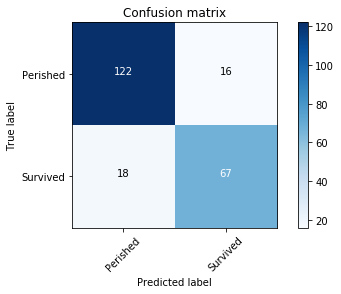

In [29]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal

In [30]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0]
Pred: [1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0]


In [31]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

## Metrics computed from a confusion matrix

The simplest metric we can use to evaluate our model is accuracy.

**Classification Accuracy:** Overall, how often is the classifier correct?

We can calculate the accuracy by dividing the number of correct classifications, by the number of observations in the test set. 

In [32]:
print((TP + TN) / float(TP + TN + FP + FN))

0.8475336322869955


There is also a metric score in sklearn that does this for you. 

In [33]:


print(metrics.accuracy_score(y_test, y_pred_class))

0.8475336322869955


This however is not always the best measure of a model's accuracy

![alt text](images/imbalanced.png)

Imagine your data looked similar to example above where you only had a few instances of the positive class. Why would accuracy be a bad measure of the model for this data?

## Precision
When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

***When the boy calls wolf, how often is there actually a wolf?***


$$\text{Precision} = \frac{TP}{TP+FP}$$

In [34]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.8072289156626506
0.8072289156626506


## Recall

What proportion of actual positives was identified correctly?

***When the wolf comes around, how many times did the boy actually spot him?***


$$\text{Recall} = \frac{TP}{TP+FN}$$

**Sensitivity:** When the actual value is positive, how often is the prediction correct?

- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"



In [35]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.788235294117647
0.788235294117647


**Specificity:** When the actual value is negative, how often is the prediction correct?

- How "specific" (or "selective") is the classifier in predicting positive instances?

In [36]:
print(TN / float(TN + FP))

0.8840579710144928


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [37]:
print(FP / float(TN + FP))

0.11594202898550725


## F1 score 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

$$F1-Score = 2\ \frac{Precision\ x\ Recall}{Precision + Recall}$$



In [38]:
#calculating the F1 score
2*(metrics.precision_score(y_test, y_pred_class)*metrics.recall_score(y_test, y_pred_class))/(metrics.precision_score(y_test, y_pred_class)+metrics.recall_score(y_test, y_pred_class))

0.7976190476190476

**Conclusion:**

- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**
- **Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- **Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

## Adjusting the classification threshold

### Precision and Recall: A Tug of War
To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa. Explore this notion by looking at the following figure.

<img src='PrecisionVsRecallBase.svg' width=900/>

Those to the right of the classification threshold are classified as "spam", while those to the left are classified as "not spam."

![alt text](images/Exam_pass_logistic_curve.jpeg)

In [39]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1])

In [40]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10, :]

array([[0.31177671, 0.68822329],
       [0.38632983, 0.61367017],
       [0.92457974, 0.07542026],
       [0.30399874, 0.69600126],
       [0.92693712, 0.07306288],
       [0.16660925, 0.83339075],
       [0.38715605, 0.61284395],
       [0.54432615, 0.45567385],
       [0.82439703, 0.17560297],
       [0.44263636, 0.55736364]])

In [41]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([0.68822329, 0.61367017, 0.07542026, 0.69600126, 0.07306288,
       0.83339075, 0.61284395, 0.45567385, 0.17560297, 0.55736364])

In [42]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [43]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

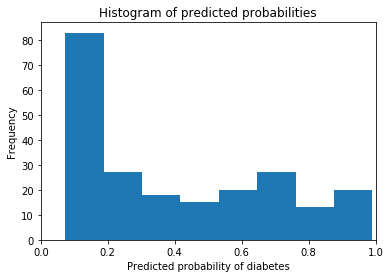

In [44]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

**Decrease the threshold** for predicting diabetes in order to **increase the sensitivity** of the classifier

In [45]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.3)[0]

In [46]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([0.68822329, 0.61367017, 0.07542026, 0.69600126, 0.07306288,
       0.83339075, 0.61284395, 0.45567385, 0.17560297, 0.55736364])

In [47]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([1., 1., 0., 1., 0., 1., 1., 1., 0., 1.])

In [48]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[122  16]
 [ 18  67]]


In [49]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[101  37]
 [  9  76]]


In [50]:
# sensitivity has increased (used to be 0.24)
print(46 / float(46 + 16))

0.7419354838709677


In [51]:
# specificity has decreased (used to be 0.91)
print(80 / float(80 + 50))

0.6153846153846154


**Conclusion:**

- **Threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions
- Threshold can be **adjusted** to increase sensitivity or specificity
- Sensitivity and specificity have an **inverse relationship**

## ROC Curves and Area Under the Curve (AUC)

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve!

## ROC curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

**True Positive Rate (TPR)** is a synonym for recall and is therefore defined as follows:

$$TPR = \frac{TP} {TP + FN}$$

**False Positive Rate (FPR)** is defined as follows:


$$FPR = \frac{FP} {FP + TN}$$


![alt text](images/perfectImbalance.png)

![alt text](images/perfectbalanceAUC.png)

![alt text](images/overlapimbalance.png)

![alt text](images/imbalancedROC.png)

## AUC: Area Under the ROC Curve
**AUC** stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

![alt text](images/perfectimbalanced.png)

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:

<img src='PrecisionVsRecallBase.svg' width=1100/>

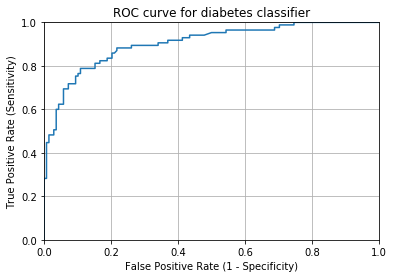

In [52]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [53]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.00724638, 0.00724638,
        0.01449275, 0.01449275, 0.02898551, 0.02898551, 0.03623188,
        0.03623188, 0.04347826, 0.04347826, 0.05797101, 0.05797101,
        0.07246377, 0.07246377, 0.0942029 , 0.0942029 , 0.10144928,
        0.10144928, 0.10869565, 0.10869565, 0.15217391, 0.15217391,
        0.16666667, 0.16666667, 0.18115942, 0.1884058 , 0.1884058 ,
        0.20289855, 0.20289855, 0.21014493, 0.2173913 , 0.2173913 ,
        0.26086957, 0.26086957, 0.34057971, 0.34057971, 0.36956522,
        0.36956522, 0.41304348, 0.41304348, 0.43478261, 0.43478261,
        0.44202899, 0.45652174, 0.47826087, 0.5       , 0.54347826,
        0.54347826, 0.55797101, 0.58695652, 0.65217391, 0.66666667,
        0.6884058 , 0.6884058 , 0.70289855, 0.70289855, 0.73913043,
        0.74637681, 0.74637681, 1.        ]),
 array([0.        , 0.01176471, 0.28235294, 0.28235294, 0.44705882,
        0.44705882, 0.48235294, 0.48235294, 0.50588235, 0.50588235,
  

- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself

In [54]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [55]:
evaluate_threshold(0.5)

Sensitivity: 0.788235294117647
Specificity: 0.8913043478260869


In [56]:
evaluate_threshold(0.3)

Sensitivity: 0.8941176470588236
Specificity: 0.7391304347826086


AUC is the **percentage** of the ROC plot that is **underneath the curve**:

In [57]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.9040068201193522


- AUC is useful as a **single number summary** of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy).

In [58]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.8508684888096653

AUC represents the probability that a random positive (green) example is positioned to the right of a random negative (red) example.

AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

AUC is desirable for the following two reasons:

- AUC is **scale-invariant**. It measures how well predictions are ranked, rather than their absolute values.
- AUC is **classification-threshold-invariant**. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.






### Two Caveats

Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.

**Confusion matrix advantages:**

- Allows you to calculate a **variety of metrics**
- Useful for **multi-class problems** (more than two response classes)

**ROC/AUC advantages:**

- Does not require you to **set a classification threshold**
- Still useful when there is **high class imbalance**

# Handling Class Imbalance

![alt text](images/imbalanced.png)

### Problems created by class imbalance
The conventional model evaluation methods do not accurately measure model performance when faced with imbalanced datasets.

Standard classifier algorithms like Decision Tree and Logistic Regression have a bias towards classes which have number of instances. They tend to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.



## Resampling
A common technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![alt text](images/resampling.png)

## Under-sampling: Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![alt text](images/tomek.png)

# Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![alt text](images/smote.png)

## Confusion Matrix Resources

- Blog post: [Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by me
- Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes) by Rahul Patwari
- Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix (by Ed Podojil)
- Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)


## ROC and AUC Resources

- Video: [ROC Curves and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo) (14 minutes) by Kevin Markham, including [transcript and screenshots](http://www.dataschool.io/roc-curves-and-auc-explained/) and a [visualization](http://www.navan.name/roc/)
- Video: [ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4) (12 minutes) by Rahul Patwari
- Paper: [An introduction to ROC analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf) by Tom Fawcett
- Usage examples: [Comparing different feature sets](http://research.microsoft.com/pubs/205472/aisec10-leontjeva.pdf) for detecting fraudulent Skype users, and [comparing different classifiers](http://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets

## Class Imbalance Resources

- Comparing Resampling Methods: [Blog](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/)
- Resampling with SKlearn: [Python Code Example](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

## Other Resources

- scikit-learn documentation: [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- Guide: [Comparing model evaluation procedures and metrics](https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md) by me
- Video: [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0) (45 minutes) about how Stripe evaluates its fraud detection model, including [slides](http://www.slideshare.net/MichaelManapat/counterfactual-evaluation-of-machine-learning-models)